
# Symulowane wyżarzanie


In [870]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

Algorytm **symulowanego wyżarzania** służy do przybliżonego znajdowania globalnego ekstremum funkcji (zwanej energią układu) zadanej na dyskretnej przesrzeni stanów $E:S->Y$. 

Algorytm przyjmuje pewien stan początkowy $s_0\in S$ oraz parametry: temperaturę $T$ i współczynnik stygnięcia $\sigma$. Algorytm zapamiętuje najbardziej opytmalny dotychczas stan $s_o\in S$. W każdej iteracji analizowany są obecnie przetwarzany stan $s_c\in S$ i generowany kolejny możliwy stan $s'\in S$. Przyjmując, że szukamy globalnego minimum, jeżeli $E(s')<E(s_c)$ to podstawiamy $s_c:=s'$. W przeciwnym wypadku z pewnym prawdopodobieństwem $p$ zadanym przez funkcję $P$ algorytm również nadpisuje $s_c:=s'$. Jest to próba uniknięcia lokalnego minimum. Następnie algorytm sprawdza, czy $E(s_o)<E(s_c)$ i jeśli tak, to $s_o=s_c$. Na koniec iteracji algorytm zmniejsza $T$ według pewnej funkcji zależnej od $\sigma$. 

Wspomniana wyżej funkcja prawdopodobieństwa zależy od $E(s')$, $E(s_c)$ oraz $T$. Powinna ona przyporządkowywać tym mniejsze prawdopodobieństwo im większa jest różnica $E(s')-E(s_c)$. Co więcej powinna zwracać większe prawdopodobieństwo dla większej wartości parametru $T$. W poniższej implementacji przyjęto, że $P = e^{\frac{E(s_c)-E(s')}{T}}$ dla $E(s_c)-E(s')<0$.

## Problem komiwojażera

W pierwszej kolejności zastosowano algorytm symulowanego wyżarzania do znalezienia przybliżonego rozwiązania problemu komiwojażera dla pełnego grafu ważonego $G=(V, E)$ zadanego na płaszczyźnie. Przestrzenią stanów jest w tym wypadku zbiór wszystkich możliwych permutacji $V$, funkcją energii natomiast suma odległości między kolejnymi wierzchołkami z danej permutacji. 

In [971]:
class Graph():
    
    def __init__(self, distribution, x, y, n):
        self.steps = []
        self.best = []
        if distribution == 'uniform':
            self.distribution = f'n = {n}, {distribution} [{x},{y}]'
            self.points = np.random.uniform(x, y, (n, 2))
        elif distribution == 'normal':
            self.distribution = f'n = {n}, {distribution} mu={x}, sigma={y}'
            self.points = np.random.normal(x, y, (n, 2))
        elif distribution == 'nine_groups':
            self.distribution = f'n = {n}, distribution'
            groups = []
            width = (y-x)/5
            for i in range(5):
                for j in range(5):
                    if i%2==0 and j%2==0:
                        x_ = np.random.uniform(x+j*width, x+(j+1)*width, n//9)
                        y_ = np.random.uniform(x+i*width, x+(i+1)*width, n//9)
                        group = [[x_[ind], y_[ind]] for ind in range(n//9)]
                        groups.append(group)
            self.points = np.concatenate(groups, axis=0)
            np.random.shuffle(self.points)
        else:
            self.points = []
            
        self.final = self.points
        
    def show_points(self, lines=False):
        #print(f'Length of route: {self.length_of_route(self.final)}')
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
        fig.suptitle(self.distribution)
        ax1.set_title(f'Length of route: {self.length_of_route(self.points)}')
        ax2.set_title(f'Length of route: {self.length_of_route(self.final)}')
        ax1.scatter(self.points[:,0], self.points[:,1])
        ax2.scatter(self.final[:,0], self.final[:,1])
        if lines:
            points_ = np.concatenate((self.points, self.points[0].reshape(1, 2)))
            ax1.plot(points_[:,0], points_[:,1])
            final_ = np.concatenate((self.final, self.final[0].reshape(1, 2)))
            ax2.plot(final_[:,0], final_[:,1])
              
        plt.show()
        
    def show_energy(self):
        #print(f'Energy function')
        #fig, ax = plt.subplots()
        #plt.scatter(self.points[:,0], self.points[:,1])
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
        #plt.plot(self.steps, color='red')
        ax1.plot(self.steps, color='red')  
        ax2.plot(self.best, color='red')  
        #plt.title(self.distribution)
        ax1.set_title(f'Current state')
        ax2.set_title(f'Best solution so far')
        plt.show()
        
    def length_of_route(self, permutation):
        n = permutation.shape[0]
        distances = [np.linalg.norm(permutation[i]-permutation[(i+1)%n]) for i in range(n)]
        return np.sum(distances)
    
    def next_permutation(self, permutation_, mode):
        permutation = permutation_.copy()
        n = len(permutation)
        if mode=='arbitrary_swap':
            [i, j] = np.random.randint(n, size=2)
            permutation[[i, j]] = permutation[[j, i]]
        elif mode=='consecutive_swap':
            i = np.random.randint(n)
            permutation[[i, (i+1)%n]] = permutation[[(i+1)%n, i]]
        return permutation
    
    def probability_fun(self, current_energy, next_energy, temperature):
        if next_energy<current_energy:
            return 1.0
    
        return np.exp((current_energy-next_energy)/temperature)
    
    def T_function(self, temperature, cooling_rate, function):
        if function=='linear':
            return temperature-cooling_rate
        elif function=='expotential':
            return (1-cooling_rate)*temperature
        else:
            return 0
        
    
    def simulated_annealing(self, temperature, cooling_rate, mode='arbitrary_swap', function='expotential'):
        best_solution = self.points.copy()
        current_state = self.points.copy()
    
        eps = 10**(-6)
    
        while temperature > eps:
            next_state = self.next_permutation(current_state, mode)
            current_energy = self.length_of_route(current_state)
            next_energy = self.length_of_route(next_state)
            if self.probability_fun(current_energy, next_energy, temperature)>np.random.uniform():
                current_state = next_state
                
            self.steps.append(current_energy)
                  
            if self.length_of_route(current_state)<self.length_of_route(best_solution):
                best_solution = current_state
                
            self.best.append(self.length_of_route(best_solution))
            
            temperature = self.T_function(temperature, cooling_rate, function)
        
        self.final =  best_solution
        

### Porównanie działania dla różnych rozkładów punktów

Poniżej zaprezentowano efekt działania algorytmu dla $n\in{50, 100, 150}$ oraz dla różnych rozkładów punktów: jednostajnego, normalnego z dwoma zestawami parametrów i 9 grup punktów.

Wszędzie przyjęto $T=1000$, $\sigma = 0.003$ oraz wykładniczą funkcję zmiany temperatury.

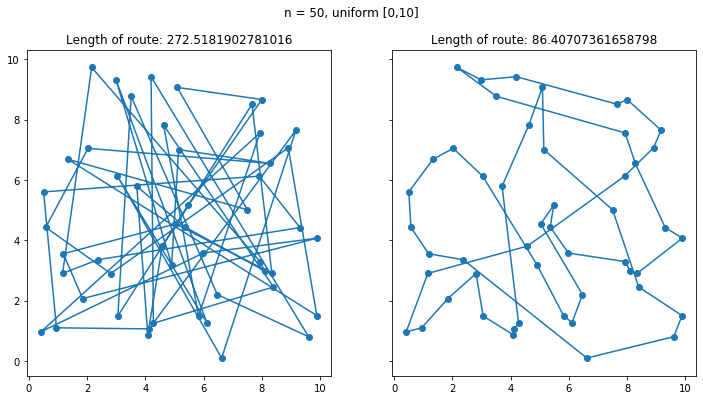

In [95]:
G = Graph('uniform', 0, 10, 50)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

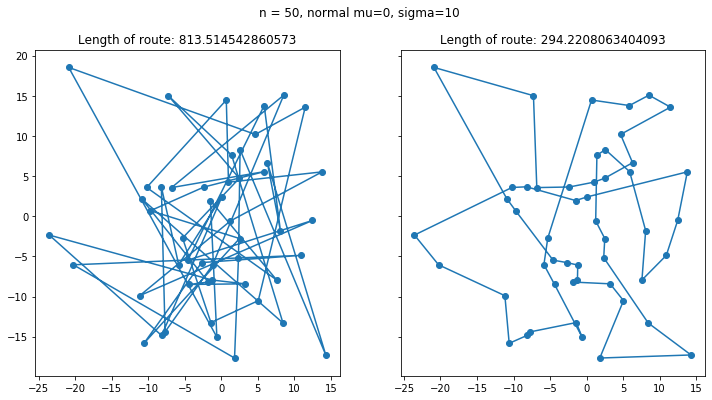

In [96]:
G = Graph('normal', 0, 10, 50)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

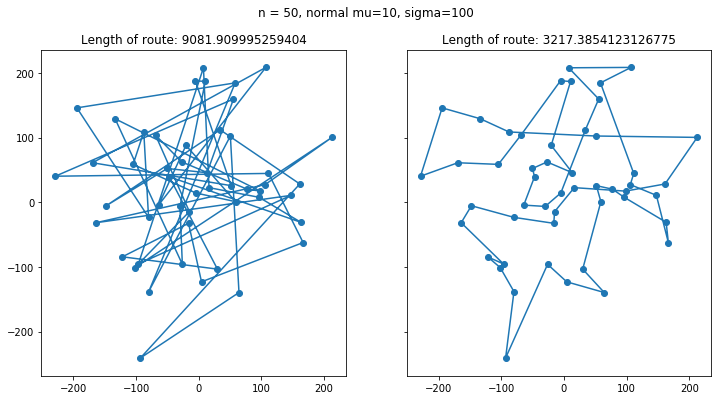

In [97]:
G = Graph('normal', 10, 100, 50)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

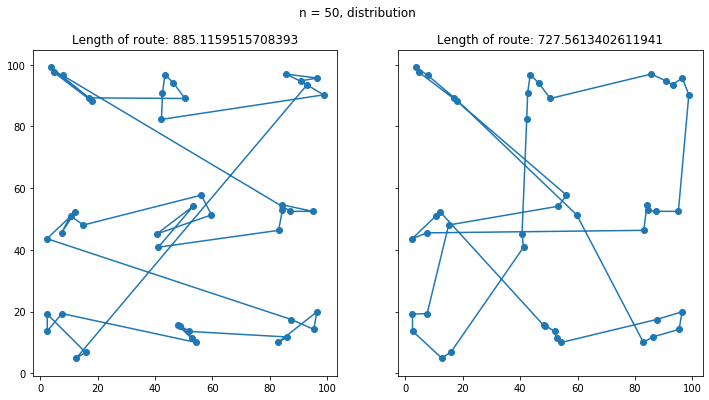

In [98]:
G = Graph('nine_groups', 0, 100, 50)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

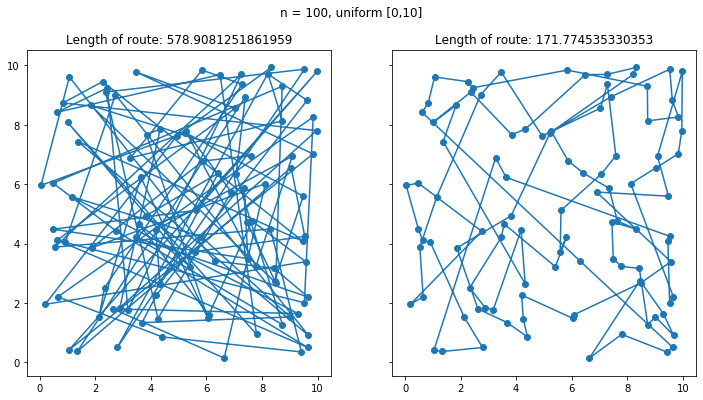

In [99]:
G = Graph('uniform', 0, 10, 100)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

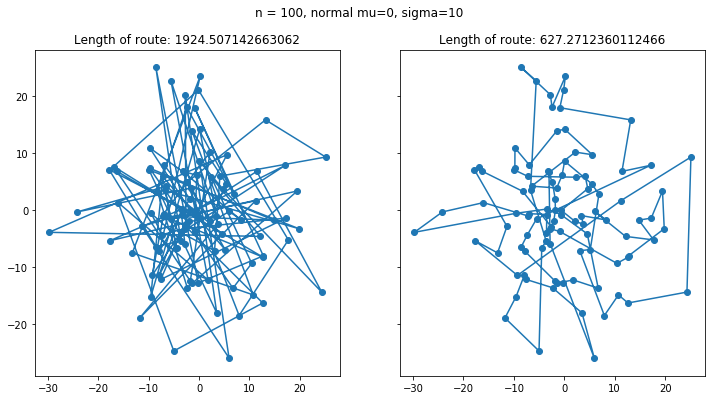

In [100]:
G = Graph('normal', 0, 10, 100)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

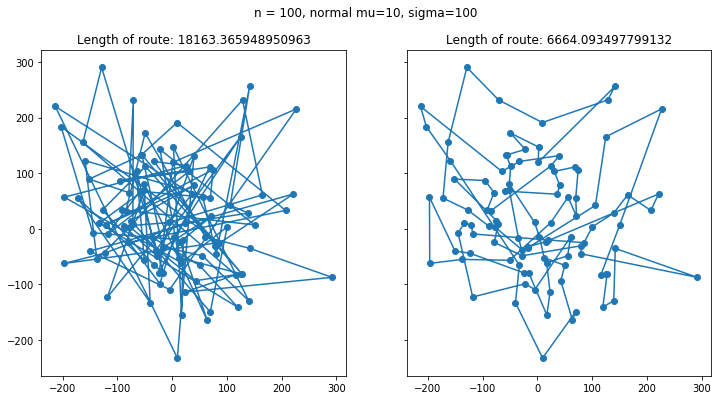

In [101]:
G = Graph('normal', 10, 100, 100)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

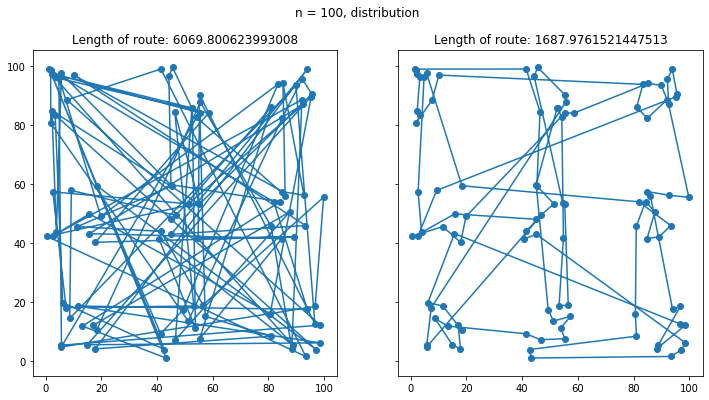

In [106]:
G = Graph('nine_groups', 0, 100, 100)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

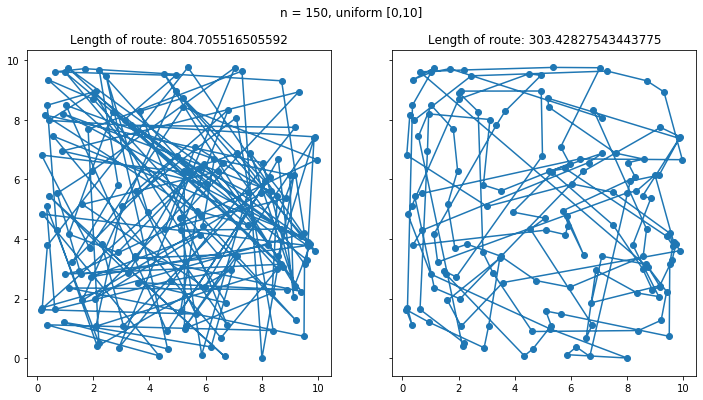

In [107]:
G = Graph('uniform', 0, 10, 150)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

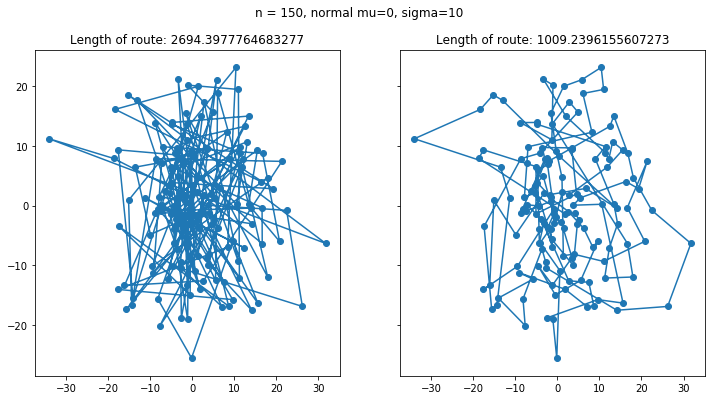

In [108]:
G = Graph('normal', 0, 10, 150)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

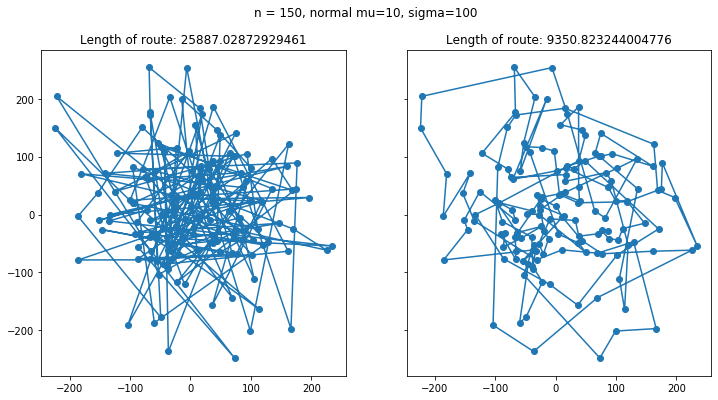

In [109]:
G = Graph('normal', 10, 100, 150)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

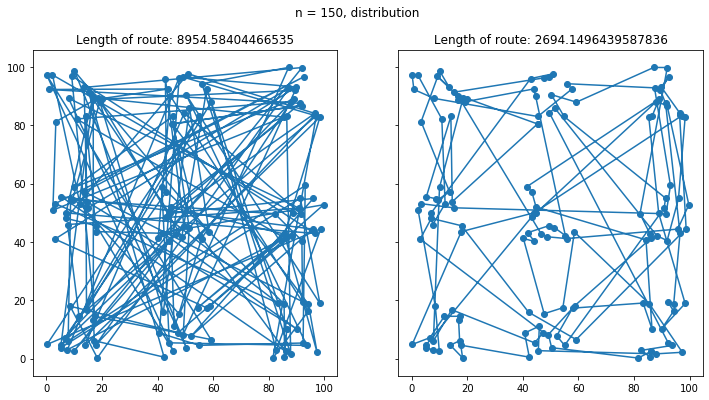

In [110]:
G = Graph('nine_groups', 0, 100, 150)
G.simulated_annealing(1000, 0.003)
G.show_points(True)

Można poczynić obserwację, że w żadnym z analizowanych przykładów nie otrzymano opytmalnego rozwiązania. Znaleziono jednak całkiem dobre jego przybliżenie. Algorytm symulowanego wyżarzania w tym przypadku lepiej sprawdził się dla mniejszysz przestrzeni stanów. Dobry efekt osiągnięto dla punktów rozmieszczonych w dziewięciu podgrupach.

### Sposoby generacji stanów i funkcje zmiany temperatury

Poniżej zaprezentowano działanie algorytmu dla dwóch metod wybierania sąsiedniego stanu:

* *consecutive swap* - zamiana losowego elementu w permutacji z jego następnikiem
* *arbitrary swp* - zamiana dwóch losowych elementów permutacji

Przyjęto $T=1000$, $\sigma = 0.003$, $n=100$, rozkład normalny punktów ~$N(0, 10)$ oraz wykładniczą funkcję zmiany temperatury.

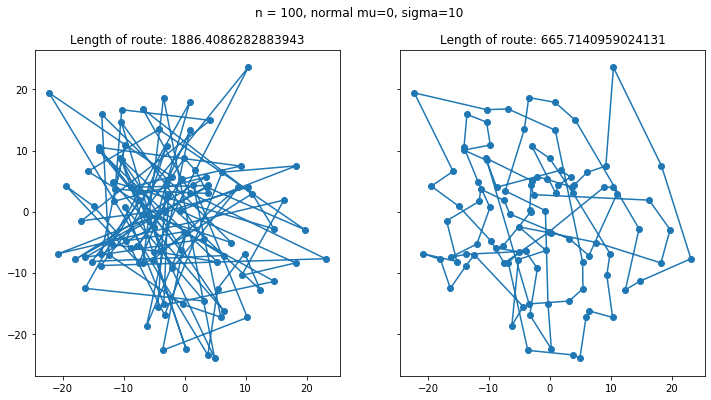

In [112]:
G = Graph('normal', 0, 10, 100)
G.simulated_annealing(1000, 0.003, mode='arbitrary_swap')
G.show_points(True)

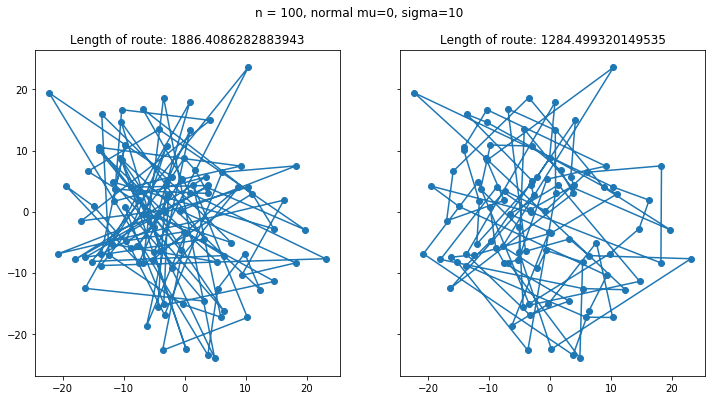

In [113]:
G.simulated_annealing(1000, 0.003, mode='consecutive_swap')
G.show_points(True)

Można zauważyć, że pozyskiwanie kolejnych stanów w trybie *arbitrary swap* daje lepsze efekty niż stosowanie *consecutive swap*.

Poniżej zaprezentowano działanie algorytmu dla dwóch funkcji zmiany temperatury:

* *linear* - liniowa zmiana temperatury o $\delta = 0.5$
* *expotential* - wykładnicza zmiana temperatury z podstawą $1 - \delta = 1 - 0.003$

Przyjęto $T=1000$, rozkład normalny punktów ~$N(0, 10)$ oraz wybór kolejnego stanu w trybie *arbitrary swap*.

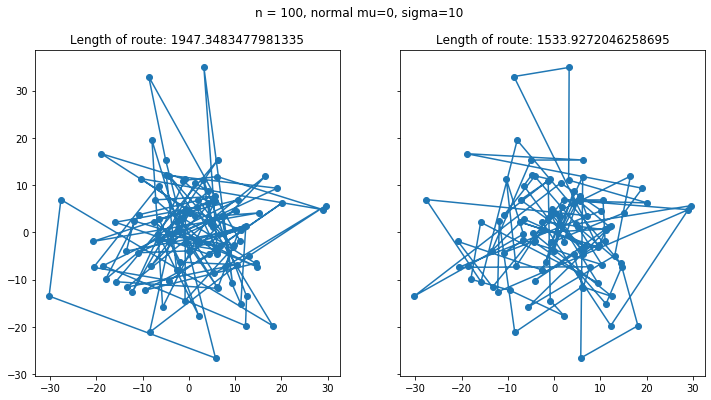

In [114]:
G = Graph('normal', 0, 10, 100)
G.simulated_annealing(1000, 0.5, function='linear')
G.show_points(True)

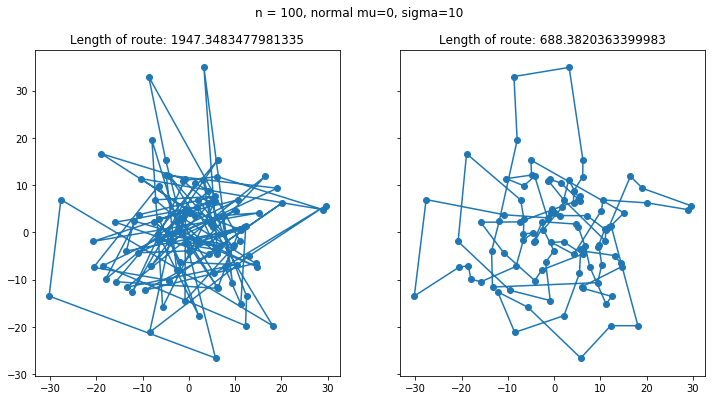

In [115]:
G.simulated_annealing(1000, 0.003, function='expotential')
G.show_points(True)

Można zauważyć, że wykładnicza zmiana temperatury daje korzystniejsze rezultaty.

### Analiza przebiegu funkcji energii

Poniżej przedstawiono działanie algorytmu dla wybranych parametrów wraz z wizualizacją zmian funkcji $E$ w zależności od obecnego stanu oraz dotychczasowo najbardziej optymalnego stanu.

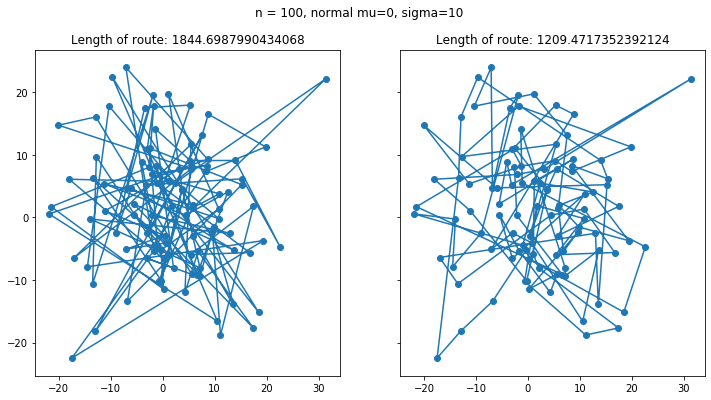

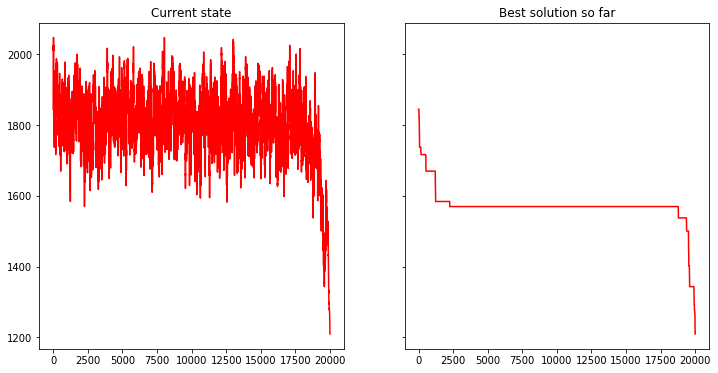

In [135]:
G = Graph('normal', 0, 10, 100)
G.simulated_annealing(1000, 0.05, function='linear')
G.show_points(True)
G.show_energy()

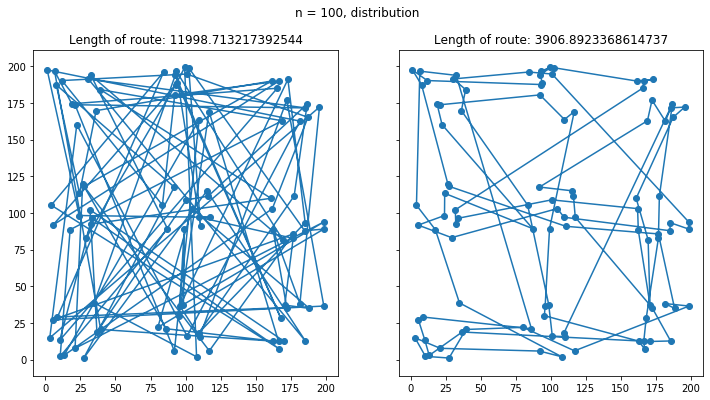

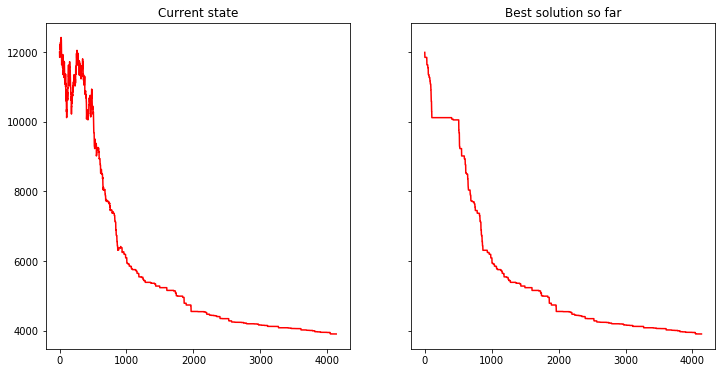

In [136]:
G = Graph('nine_groups', 0, 200, 100)
G.simulated_annealing(1000, 0.005)
G.show_points(True)
G.show_energy()

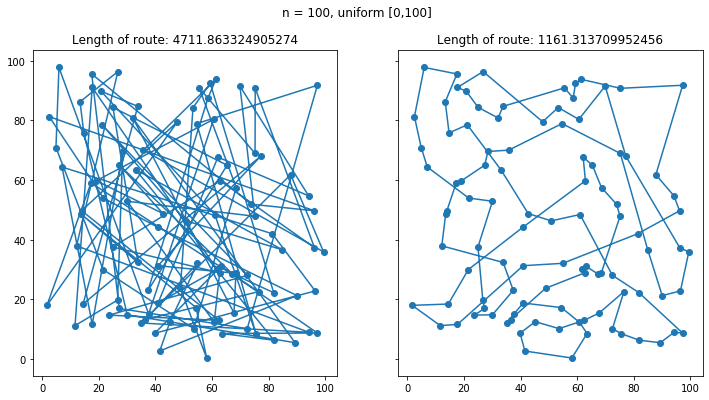

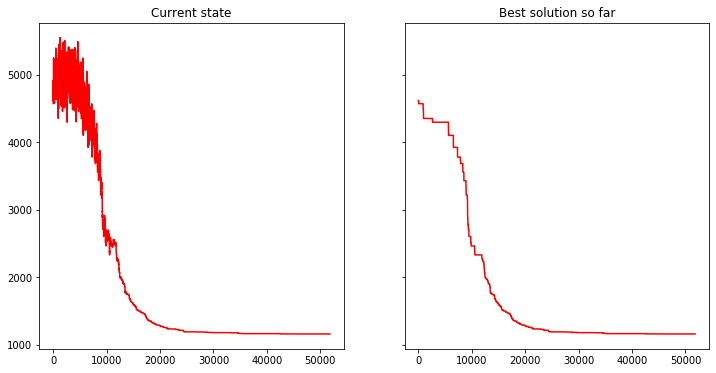

In [972]:
G = Graph('uniform', 0, 100, 100)
G.simulated_annealing(1000, 0.0004)
G.show_points(True)
G.show_energy()

We wszystkich analizowanych przypadkach funkcja energii dąży do minimum. Widoczne na wykresach piki oraz chwilowo rosnąca wartość funkcji energii od obecnego stanu odzwierciedlają wychodzenie z lokalnych minimów. W przypadku liniowej funkcji zmiany temperatury wielkość pików utrzymuje się na podobnym poziomie, natomiast dla funkcji wykładniczej początkowo widoczne piki zaczynają stopniowo zanikać - algorytm początkowo chętniej eksploruje przestrzeń stanów. Prawdopodobnie właśnie to powoduje, że z użyciem funkcji wykładniczej otrzymujemy lepsze wyniki.  

## Obraz binarny

Algorytm symulowanego wyżarzania może prowadzić również do powstania ciekawych obrazów binarnych. Poniżej zaimplementowano klasę *Image*, która reprezentuje obraz binarny. Początkowo jest to losowo wygenerowany obraz $n\times n$ z gęstością czarnych pikseli zadanych przez $\rho$. 

W celach optymalizacyjnych w każdym kroku obliczana jest jedynie $\Delta E$ i na tej podstawia aktualizowana jest funkcja energii. Zaproponowane funkcje energii zależą od:
* sąsiedztwa - można wybrać, czy pod uwagę branych jest $4$, $8$ czy $8-16$ sąsiadów, sąsiedztwo zawija się na brzegach
* współczynników przyciągania i odpychania - piksele tego samego koloru w sąsiedztwie zmniejszają funkcję energii według współczynnika $r_p$, piksele różnego koloru w sąsiedztwie zwiększają funkcję energii
* położenia na planszy - analizowano funkcję energii, która dla pojedyńczego piksela zależy od jego lokalizacji w obrazie.

Stany sąsiednie generowano na 2 sposoby:
* zastąpienie koloru $m$ losowo wybranych pikseli kolorem przeciwnym
* zamiana kolorami w $m$ losowo wybranych parach punktów.

Standardowo dla algorytmu symulowanego wyżarzania można wybrać początkową temperaturę $T$ i współczynnik stygnięcia $\delta$. We wszystkich przykładach zastosowano wykładniczą zmianę temperatury zależną tylko od współczynnika stygnięcia.




In [389]:
class Image():
    
    def __init__(self, rho, n):
        self.img = np.random.choice([0.0, 1.0], (n,n), p=[1-rho, rho]) 
        self.n = n
        self.rho = rho
        self.final = self.img
        
        self.steps = []
        self.temp = []
        
        self.nbh = None
        self.r_p = None
        self.r_o = None
        self.m = None
        self.start_energy = None
        self.final_energy = None
        self.n_state_type = None
        self.w = None
        self.k = None
        
    def energy(self, c_img):
        E=0            
        
        for y in range(self.n):
            for x in range(self.n):
                E+=self.delta_energy(x, y, c_img)
                
        return E
    
    def delta_energy(self, x_i, y_i, c_img):
        E=0
       
        for (dx,dy) in self.nbh:
            if self.w:
                w_ = x_i+y_i
            elif self.k:
                if np.power(x_i-50, 2)+np.power(y_i-50, 2)<=100:
                    w_ = 1.
                else:
                    w_ = -1.
            else:
                w_ = 1.
                
            if c_img[x_i][y_i]==c_img[(x_i+dx)%self.n][(y_i+dy)%self.n]:
                E-=(self.r_p*w_)
            else:
                E+=(self.r_o*w_)
                
        return E
    
    def n_state(self, state, energy):
        next_state = state.copy()
        
        if self.n_state_type=='swap':
            for i in range(self.m):
                [[x1,y1], [x2, y2]] = np.random.choice(self.n, (2,2))
                energy-=self.delta_energy(x1, y1, next_state)
                energy-=self.delta_energy(x2, y2, next_state)
                next_state[x1][y1], next_state[x2][y2] = next_state[x2][y2], next_state[x1][y1]
                energy+=self.delta_energy(x1, y1, next_state)
                energy+=self.delta_energy(x2, y2, next_state)
                
        elif self.n_state_type=='replace':
            for i in range(self.m):
                [x, y] = np.random.choice(self.n, 2)
                energy-=self.delta_energy(x, y, next_state)
                next_state[x][y] = -1.0*(next_state[x][y]-1.0)
                energy+=self.delta_energy(x, y, next_state)
            
        return (next_state, energy)
    
    def probability_fun(self, current_energy, next_energy, temperature):
        if next_energy<current_energy:
            return 1.0
    
        return np.exp((current_energy-next_energy)/temperature)    
        
    
    def simulated_annealing(self, temperature, cooling_rate, m=10, nbh=4, r_p=1, r_o=1, 
                            n_state_type = 'replace', w=False, k=False, linear=False):
        self.k = k
        self.m = m
        self.n_state_type = n_state_type
        self.w = w
        
        if nbh==4:
            self.nbh = [(x, y) for x in range(-1, 2) for y in range(-1, 2) if abs(x)!=abs(y)]
        elif nbh==8:
            self.nbh = [(x, y) for x in range(-1, 2) for y in range(-1, 2) if x!=0 or y!=0]
        else:
            self.nbh = [(x, y) for x in range(-2, 3) for y in range(-2, 3) if x!=0 or y!=0]
        
        self.r_p = r_p
        self.r_o = r_o
        
        best_solution = self.img.copy()
        best_energy = self.energy(best_solution)
        current_state = self.img.copy()
        current_energy = best_energy
        
        self.start_energy = best_energy
    
        eps = 10**(-5)
    
        while temperature > eps:
            next_state, next_energy = self.n_state(current_state, current_energy)
    
            if self.probability_fun(current_energy, next_energy, temperature)>np.random.uniform():
                current_state = next_state
                current_energy = next_energy
            
            self.steps.append(current_energy)
            self.temp.append(temperature)
                  
            if current_energy<best_energy:
                best_solution = current_state
                best_energy = current_energy
                
            if linear:
                temperature = temperature-cooling_rate
            else:
                temperature = (1-cooling_rate)*temperature
        
        self.final = best_solution 
        self.final_energy = best_energy
        
    def show_img(self):
        fid, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
        ax1.imshow(self.img, cmap='Greys')        
        ax2.imshow(self.final, cmap='Greys')
        ax1.set_title(f'Energy: {self.start_energy}')
        ax2.set_title(f'Energy: {self.final_energy}')
        plt.show()
        
    def show_energy_temperature(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
        ax1.plot(self.steps, color='red')  
        ax2.plot(self.temp, color='red')  
        ax1.set_title(f'Energy')
        ax2.set_title(f'Temperature')
        ax2.set_xlim(0, 3500)
        plt.show()
        self.steps = []
        self.temp = []

### Różne sąsiedztwo

Poniżej zaprezentowano wyniki otrzymane dla różnych sąsiedztw i różnych sposobów generowania stanów sąsiednich oraz różnej początkowej zawartości czarnych pikseli $\rho$.

Energia pojedyńczego piksela nie zależy od jego lokalizacji. Pozostałe parametry ustalono:
$r_o=r_p=1$, $m=1$, $T=1000$, $\delta = 0.005$.

Przy parametrach jak w poniższym wywołaniu funkcji, dla $\rho=0.1$ nie zaobserwowano żadnych zmian w obrazie. Natomiast dla $\rho \in {0.3, 0.4}$ wzrosła gęstość czarnych pikseli i zgrupowały się one. Bardzo podobne wyniki zaobserwowano dla sąsiedztw 4 i 8, dlatego poniżej zamieszczono tylko jeden z nich. Nie obserwujemy zmian dla $\rho=0.1$, gdyż taki początkowy stan ma już i tak bardzo małą energię - wiele białych pikseli jest zgromadzonych koło siebie.

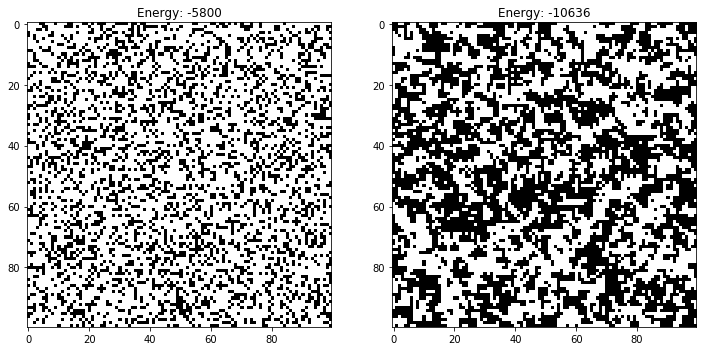

In [304]:
i = Image(rho=0.3, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=4, n_state_type='replace')
i.show_img()

Dla sąsiedztwa 8-16 i $\rho=0.1$ również nie zaobserwowano zmiany obrazu. Natomiast dla $\rho \in {0.3, 0.4}$ piksele ponownie zgrupowały się w jednokolorowe powierzchnie - tym razem trochę większe niż dla pozostałych sąsiedztw.

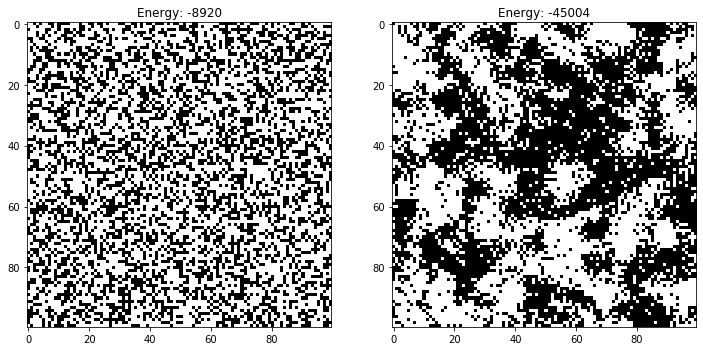

In [313]:
i = Image(rho=0.4, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=24, n_state_type='replace')
i.show_img()

Jeśli zamiast zastępować piksele będziemy zamieniać je miejscami, zaobserwujemy działanie algorytmu również dla małej gęstości czarnych pikseli. Można zauważyć, że przy poprzedniej funkcji generacji stanu algorytm osiągał grupowanie poprzez dodawanie czarnych pikseli wokół już istniejących (jeśli było to optymalne), natomiast teraz udaje mu sie osiągnąć grupowanie również bez dodawania czaarnych pikseli.

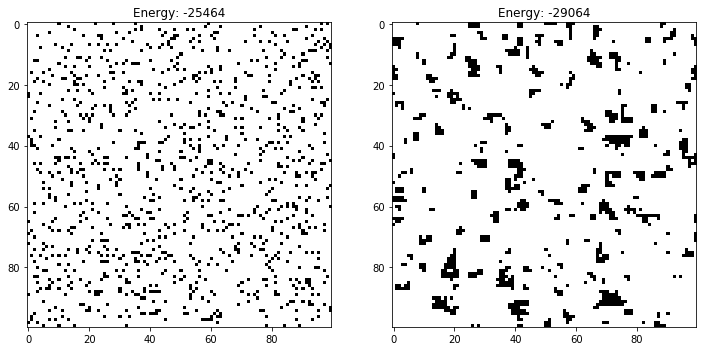

In [315]:
i = Image(rho=0.1, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=4, n_state_type='swap')
i.show_img()

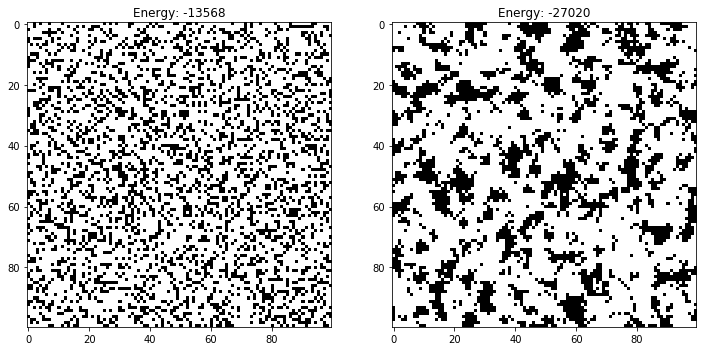

In [321]:
i = Image(rho=0.3, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=8, n_state_type='swap')
i.show_img()

Wyniki otrzymane dla sąsiedztwa 4 i 8 są bardzo podobne, dlatego powyżej zaprezentowano po jednym przykładzie. 

Natomiast dla sąsiedztwa 8-16 otrzymane grupy pikseli są ponownie większe.

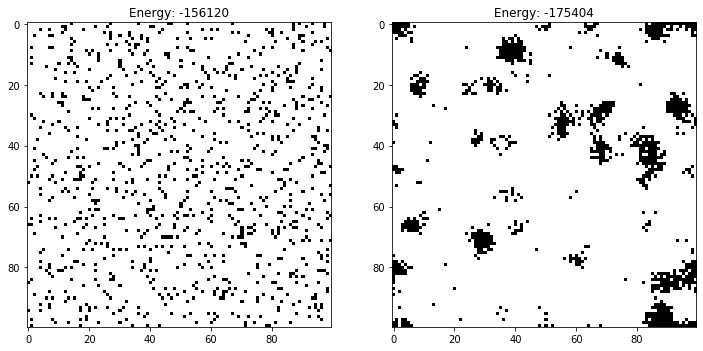

In [320]:
i = Image(rho=0.1, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=24, n_state_type='swap')
i.show_img()

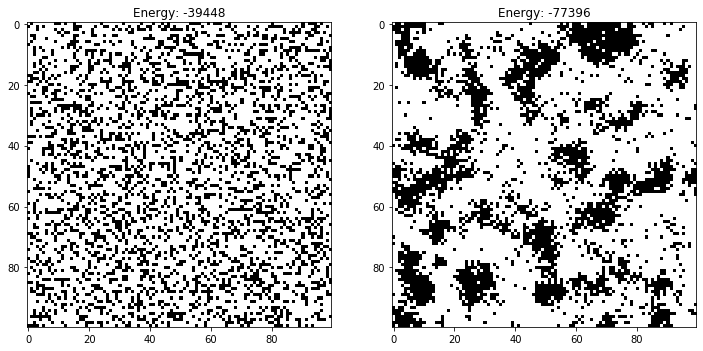

In [322]:
i = Image(rho=0.3, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=24, n_state_type='swap')
i.show_img()

### Różne funkcje energii

Poniższą analizę przeprowadzono przy następujących parametrach:
* kolejny stan jest wyznaczany poprzez zamianę par pikseli
* gęstość czarnych pikseli wynosi $\rho \in {0.1, 0.3, 0.5}$ w zależności od przykładu
* $T=1000$, $\delta = 0.005$

W pierwszej kolejności przetestowano ustawienie parametrów $r_o=r_p=-1.0$. Jest to funkcja energii, która preferuje piksele różnych kolorów w sąsiedztwie. Tym sposobem otrzymano obrazy, gdzie piksele zamiast w płaty układają się w korytarze - okazuje się, że to właśnie one gwarantują stan o największym rozproszeniu kolorystycnzym.

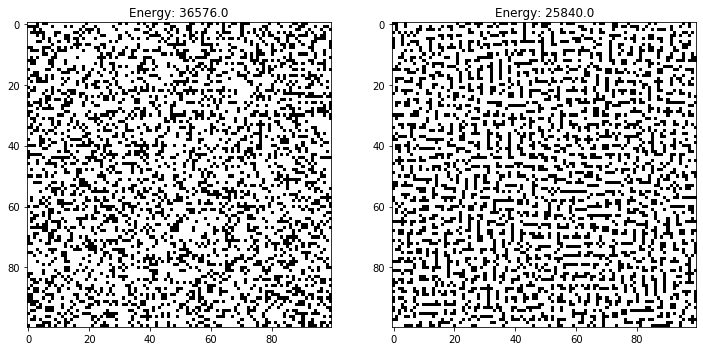

In [325]:
i = Image(rho=0.3, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=24, n_state_type='swap', r_o=-1.0, r_p=-1.0)
i.show_img()

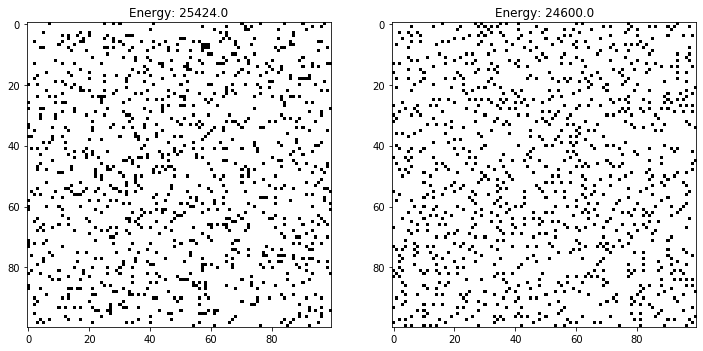

In [334]:
i = Image(rho=0.1, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=4, n_state_type='swap', r_o=-1.0, r_p=-1.0)
i.show_img()

Następnie wybrano funkcję energii, która zależy nie tylko od sąsiedztwa, ale też od położenia piksela w obrazie. 
W pierwszej kolejności funkcja energii preferuje podobieństwo w sąsiedztwie dla pikseli o większej sumie współrzędnych (odwrócony układ współrzędnych, zgodnie z numeracją tablic), następnie funkcja preferuje porządek wewnątrz koła na środku obrazka. Widać, że algorytm symulowanego wyżarzania pozwala generować bardzo ciekawe wzory.

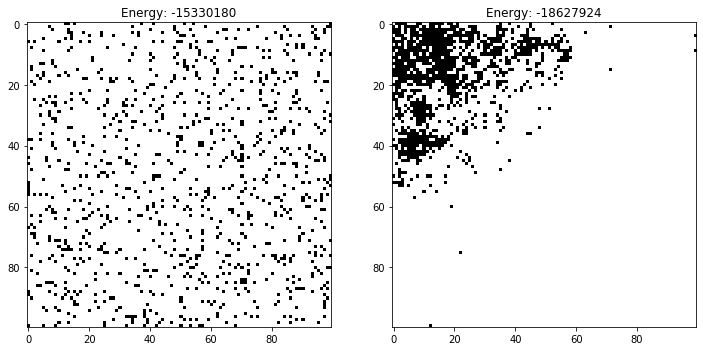

In [326]:
i = Image(rho=0.1, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=24, n_state_type='swap', w=True)
i.show_img()

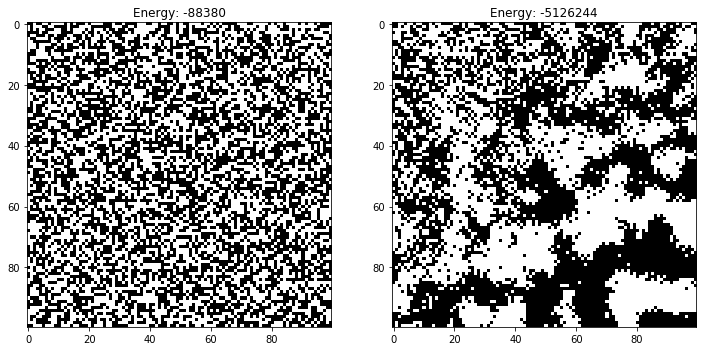

In [327]:
i = Image(rho=0.5, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=24, n_state_type='swap', w=True)
i.show_img()

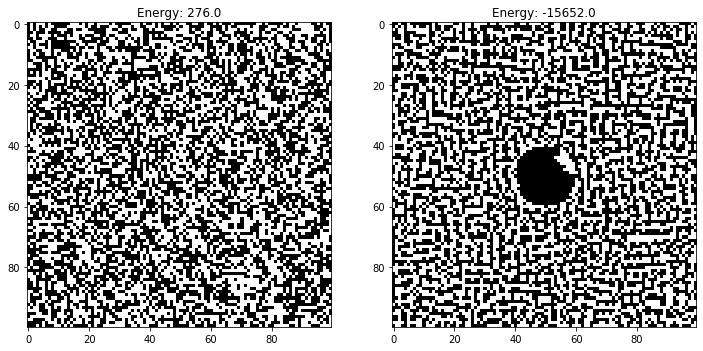

In [333]:
i = Image(rho=0.5, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=24, n_state_type='swap', k=True)
i.show_img()

### Szybkość zmiany temperatury

Na koniec obserwowano wyniki dla różnych szybkości chłodzenia systemu, dla jednego z powyższych zestawów paramerów. Analiowano zależność liniową oraz wykładniczą o różnej podstawie.

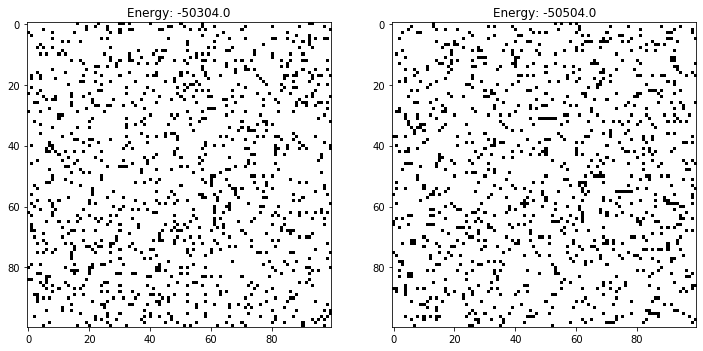

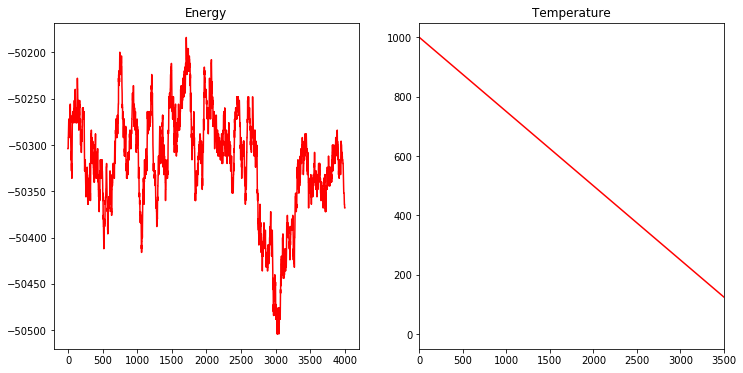

In [394]:
i = Image(rho=0.1, n=100)
i.simulated_annealing(temperature=1000, cooling_rate=0.25, nbh=8, n_state_type='swap', linear=True)
i.show_img()
i.show_energy_temperature()

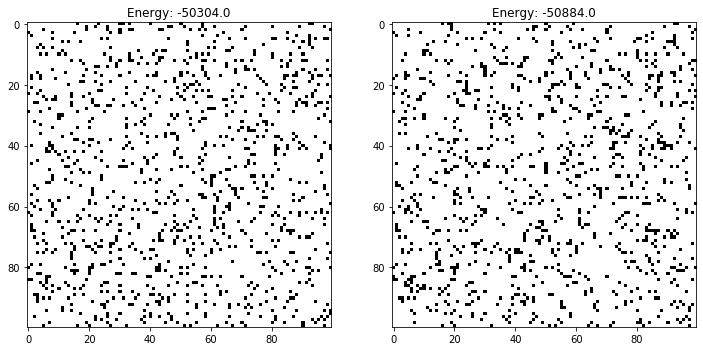

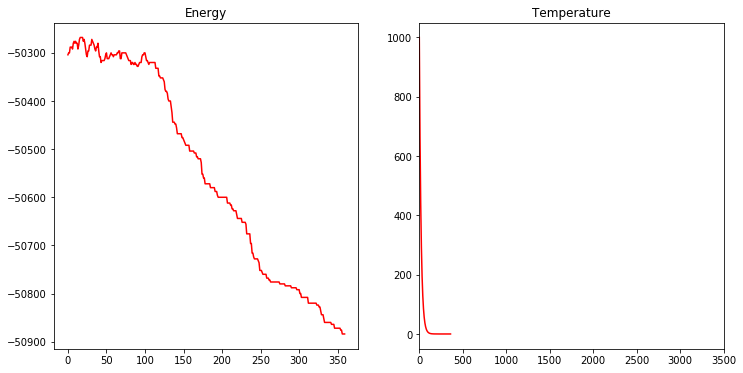

In [395]:
i.simulated_annealing(temperature=1000, cooling_rate=0.05, nbh=8, n_state_type='swap')
i.show_img()
i.show_energy_temperature()

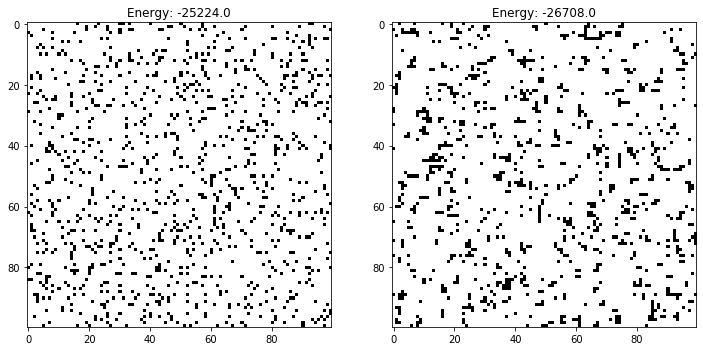

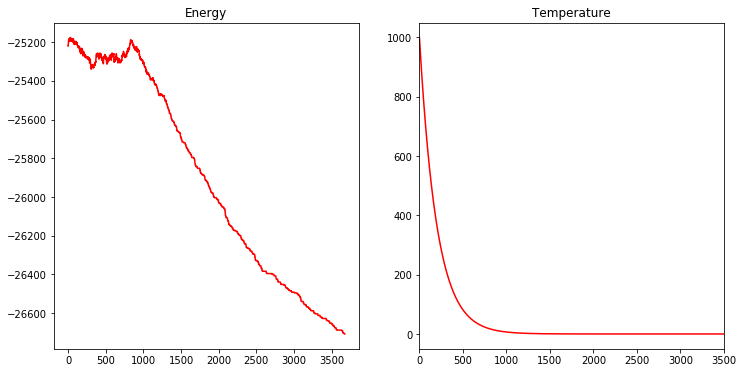

In [396]:
i.simulated_annealing(temperature=1000, cooling_rate=0.005, nbh=4, n_state_type='swap')
i.show_img()
i.show_energy_temperature()

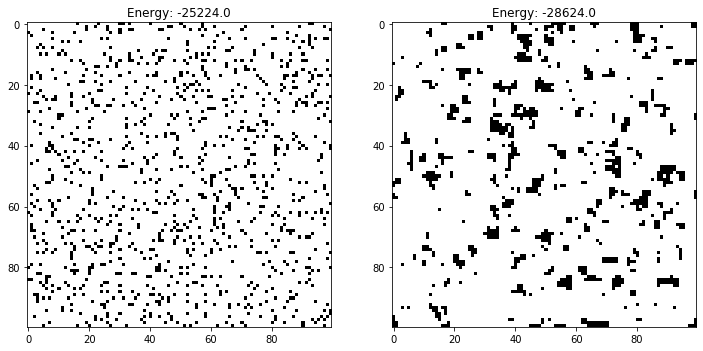

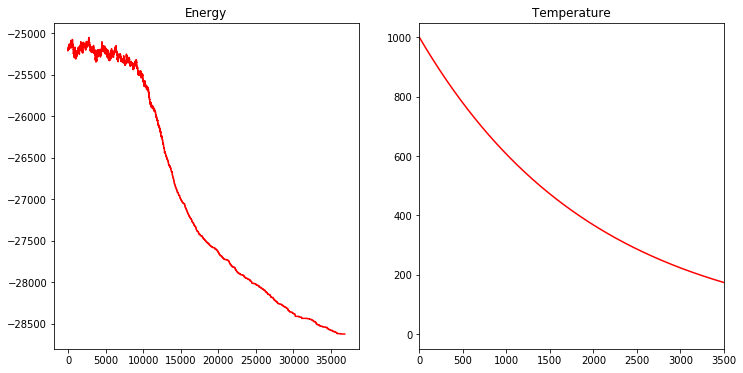

In [397]:
i.simulated_annealing(temperature=1000, cooling_rate=0.0005, nbh=4, n_state_type='swap')
i.show_img()
i.show_energy_temperature()

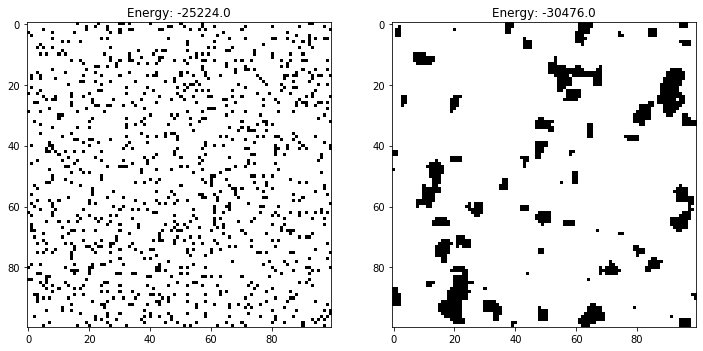

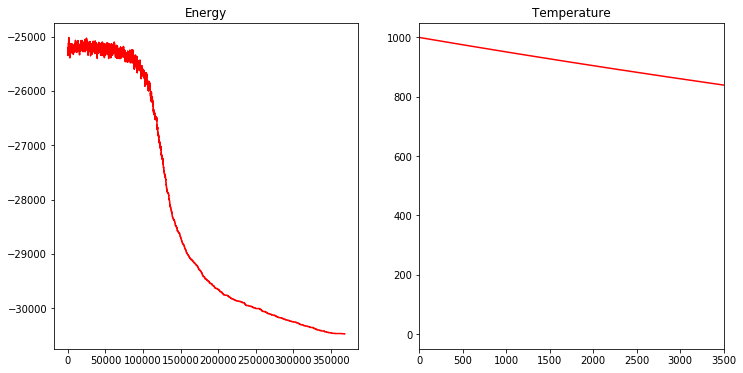

In [398]:
i.simulated_annealing(temperature=1000, cooling_rate=0.00005, nbh=4, n_state_type='swap')
i.show_img()
i.show_energy_temperature()

Na wykresie ustalono stałą podziałkę na osi $OX$ aby widać było, jak różnią się funkcje. Można zaobserwować, że szybkość zmiany temperatury mocno wpływa na końcowy wynik. Zarówno rodzaj funkcji jak i jej wenętrzne parametry decydują o tym jak kolejny stan jest wybierany. Najciekawsze wyniki obserwuje się gdy zarówno losowe przeszukiwanie przestrzeni stanów jak i zbieganie do minimum mogą potrwać dłużej - stąd wynik funkcji wykładniczej o małym współczynniku stygnięcia (bliskiej 1 podstawie funkcji czyli $1-\delta$).

## Sudoku

Na koniec zastosowano algorytm symulowanego wyżarzania do rozwiązywania sudoku. Z pliku tekstowego wczytywane było przykładowe sudoku z różną liczbą uzupełnionych cyfr. Jako funkcję energii przyjęto sumę liczby powtórzeń cyfr w wierszu, liczby powtórzeń cyfr w kolumnie i liczby powtórzeń cyfr w blokach $3\times 3$. W celu zoptymalizowania czasu działania algorytmu w każdej iteracji liczono jedynie $\Delta E$ dla zamienionych elementów i na tej podstawie aktualizowano funkcję energii. Algorytm kończył działanie, gdy $E=0$, gdyż jest to minimum zdefiniowanej funkcji energii.

Przetestowano 2 metody generowania stanu początkowego:
* uzupełnianie kolejnych wolnych miejsc kolenymi cyframi w brakującej ilości,
* uzupełnianie w taki sposób, aby cyfry w wierszach nie powtarzały się,
nie zaobserwowano jednak szczególnej różnicy w działaniu algorytmu przy różnych inicjalizacjach.

Kolejne stany generowano poprzez zamienienie miejscami 2 cyfr (z wyjątkiem cyfr, które były obecne od samego początku).

Parametry wejściowe ustalono następująco $T=100$, $\sigma=0.00005$. W porównaniu z poprzednimi zadaniami zwiększono również temperaturę, przy której algorytm kończy działanie. Było to spowodowane obserwacją, że przy poprzednim ustaleniu, algorytm dość szybko przyjmował określony stan energii i utrzymywał go na stałym poziomie do końca swojego działania.

In [954]:
class Sudoku():
    
    def __init__(self, file_path, unique_in_rows = False, simpler = False):
        self.iterations = 0
        self.runs = 0
        self.simpler = simpler
        self.unique_in_rows = simpler or unique_in_rows
        self.steps = []
        self.board = []
        f = open(file_path, 'r')
        x = f.readlines()
        f.close()
        
        for i in x:
            self.board.append(np.fromstring(i.replace('x', '0'), dtype=int, sep=' '))
            
        self.board = np.array(self.board)        
        self.free = []
        for i in range(9):
            self.free.append([x for x in range(9) if self.board[i][x]==0])
        
        if self.unique_in_rows:
            for i in range(9):
                numbers = np.unique(self.board[i])
                n = 1
                for j in range(9):
                    if self.board[i][j]==0:
                        while np.asscalar(np.isin(n, np.array(numbers))):
                            n+=1
                        self.board[i][j] = n
                        n+=1
                        
        else:      
            numbers, counts = np.unique(self.board, return_counts=True)       
            for n in range(10):
                if not np.asscalar(np.isin(n, np.array(numbers))):
                    numbers = np.append(numbers, n)
                    counts = np.append(counts, 0)
        
            ind = 0    
            for (n, c) in zip(numbers[1:], counts[1:]):
                for k in range(c, 9):
                    while ind//9<9 and self.board[ind//9,ind%9] != 0:
                        ind+=1
                    if ind//9<9:
                        self.board[ind//9][ind%9] = n
                    
        
    def energy(self, board):
        E=0  
        for x_i in range(9):
            numbers, counts = np.unique(board[:,x_i], return_counts=True)
            E+=np.sum(counts-1)
        
        for y_i in range(9):
            numbers, counts = np.unique(board[y_i], return_counts=True)
            E+=np.sum(counts-1)
        
        for y_s in [0, 3, 6]:
            for x_s in [0, 3, 6]:
                numbers, counts = np.unique(board[y_s:y_s+3,x_s:x_s+3], return_counts=True)
                E+=np.sum(counts-1) 
                
        return E
    
    def delta_energy(self, x_i, y_i, board):
        E=0

        numbers, counts = np.unique(board[x_i], return_counts=True)
        E+=np.sum(counts-1)

        numbers, counts = np.unique(board[:,y_i], return_counts=True)
        E+=np.sum(counts-1)
        
        y_s = 3*(y_i//3)
        x_s = 3*(x_i//3)
        numbers, counts = np.unique(board[x_s:x_s+3,y_s:y_s+3], return_counts=True)
        E+=np.sum(counts-1)     
                
        return E
    
    def n_state(self, state, energy):
        next_state = state.copy()
        
        r1 = np.random.choice(9)
        while len(self.free[r1])==0:
            r1 = (r1+1)%9
            
        if self.simpler:
            r2 = r1
        else:
            r2 = np.random.choice(9)
            while len(self.free[r2])==0:
                r2 = (r2+1)%9
        x1 = np.random.choice(self.free[r1])
        x2 = np.random.choice(self.free[r2])

        energy-=self.delta_energy(r1, x1, next_state)
        energy-=self.delta_energy(r2, x2, next_state)
        next_state[r1][x1], next_state[r2][x2] = next_state[r2][x2], next_state[r1][x1]
        energy+=self.delta_energy(r1, x1, next_state)
        energy+=self.delta_energy(r2, x2, next_state)
                    
        return (next_state, energy)
    
    def probability_fun(self, current_energy, next_energy, temperature):
        if next_energy<current_energy:
            return 1.0
    
        return np.exp((current_energy-next_energy)/temperature)
        
    
    def simulated_annealing(self, temperature, cooling_rate):
        
        self.runs +=1

        best_solution = self.board.copy()
        best_energy = self.energy(best_solution)
        current_state = self.board.copy()
        current_energy = best_energy
    
        eps = 10**(-2)
    
        while temperature > eps and best_energy>0:
            self.iterations += 1
            next_state, next_energy = self.n_state(current_state, current_energy)
    
            if self.probability_fun(current_energy, next_energy, temperature)>np.random.uniform():
                current_state = next_state
                current_energy = next_energy
                
            self.steps.append(current_energy)
                  
            if current_energy<best_energy:
                best_solution = current_state
                best_energy = current_energy
                
            temperature = (1-cooling_rate)*temperature
        
        self.board = best_solution 
        
    def show_information(self):
        plt.plot(self.steps, color='red')  
        print(self.board)
        print(f'Number of iterations: {self.iterations}')
        print(f'Number of algorithm runs: {self.runs}')
        print(f'Correctness: {self.check_correctness()}')
        plt.show()
        
    def check_correctness(self):
        return self.energy(self.board)==0

In [950]:
def gather_data(data, simpler=False):
    for i in range(5, 75, 5):
        S = Sudoku(f'sudoku{i}', simpler=simpler)
        S.simulated_annealing(100, 0.00005)
        print(f'sudoku{i} done')
        data.append((i, cp.deepcopy(S)))
    return data

def second_run(data):
    for S in data:
        S[1].simulated_annealing(100, 0.00005)
        
    return data
        
def draw(data):
    x = [s[0] for s in data if s[1].check_correctness()] 
    y = [s[1].iterations for s in data if s[1].check_correctness()]
    
    fig, ax = plt.subplots()
    plt.bar(x, y, width=2.5)
    plt.title('Number of iterations')
    plt.xticks(x, x)
    plt.show()

W poniższej analizie szukano rozwiązania sudoku, które ma się prezentować następująco.

In [969]:
s = Sudoku('sudoku0')
print(s.board)

[[7 5 9 4 8 2 3 6 1]
 [6 2 3 1 5 9 8 4 7]
 [8 1 4 6 3 7 2 5 9]
 [1 8 7 2 4 3 6 9 5]
 [5 4 2 8 9 6 1 7 3]
 [9 3 6 5 7 1 4 2 8]
 [2 7 8 3 6 5 9 1 4]
 [4 9 1 7 2 8 5 3 6]
 [3 6 5 9 1 4 7 8 2]]


Na poniższym wykresie zaprezentowano liczbę iteracji potrzebną do uzyskania rozwiązania sudoku w zależności od liczby wolnych miejsc na planszy. Na osi $OX$ Uwzględniono tylko te plansze, dla których uzyskano prawidłowy wynik.

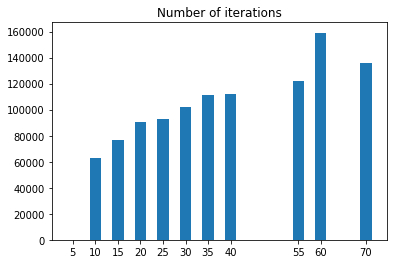

In [943]:
#solved = []
#solved = gather_data(solved)
draw(solved)

Zaobserwowano, że algorytmowi zdaża się utknąć w lokalnym minimum, gdzie funkcja energii wynosi 2. Tym samym algorytm symulowanego wyżarzania nie był w stanie znaleźć rozwiązania dla wszystkich początkowych układów (testowano również plansze o innym rozwiązaniu). Ponieważ dla większej liczby wolnych miejsc algorytm nie znajdował optymalnego rozwiązania, uruchomiono go ponownie - inicjalizując stan poprzednim rozwiązaniem. Wyniki zaprezentowano na poniższym wykresie.

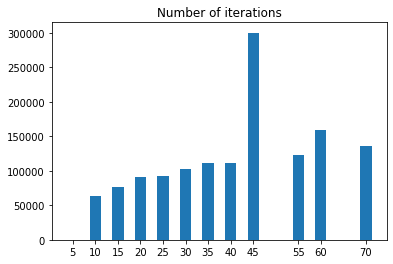

In [944]:
#solved2 = cp.deepcopy(solved)
#solved2 = second_run(solved2)
draw(solved2)

Uzyskano dodatkowe rozwiązanie jedynie dla 45 pustych miejsc na planszy.

Zadanie znalezienia rozwiązania sudoku postawione w powyższej formie okazało się zbyt trudne dla zbyt dużej liczby wolnych pozycji, dlatego postanowiono trochę uprościć zadanie. Początkowo tablicę zainicjalizowano tak, aby w każdym wierszu były tylko unikalne wartości. Kolejne stany generowano poprzez zamianę losowych elementów w tym samym wierszu.

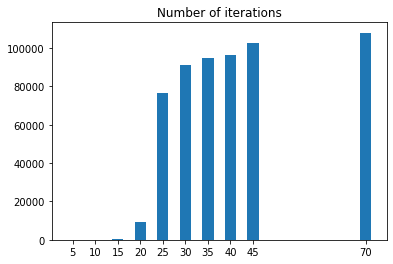

In [957]:
#solved_sim = []
#solved_sim = gather_data(solved_sim)
draw(solved_sim)

Wbrew oczekiwaniom zadanie nie okazało sie prostsze-dla więcej niż 45 wolnych miejsc algorytm w dalszym ciągu ma problem ze znalezieniem rozwiązania. Jeżeli jednak je znajduje, robi to szybciej. Ponownie powtórzono drugie uruchomienie algorytmu, poczynając od stanu poprzedniego i ponownie udało sie uzyskać kolejne 2 rozwiązania.

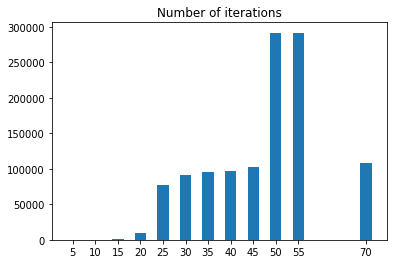

In [959]:
#solved_sim2 = cp.deepcopy(solved_sim)
#solved_sim2 = second_run(solved_sim2)
draw(solved_sim2)

Na koniec zaprezentowano przykładowe wyniki z pierwszej wersji algorytmu wraz z przebiegiem funkcji energii.

[[4 5 1 2 9 8 3 6 7]
 [6 7 2 1 5 3 9 4 8]
 [9 8 3 6 7 4 2 5 1]
 [1 3 8 9 4 6 7 2 5]
 [5 9 4 8 2 7 6 1 3]
 [7 2 6 5 3 1 4 8 9]
 [2 4 7 3 8 5 1 9 6]
 [8 1 9 7 6 2 5 3 4]
 [3 6 5 4 1 9 8 7 2]]
Number of iterations: 135645
Number of algorithm runs: 1
Correctness: True


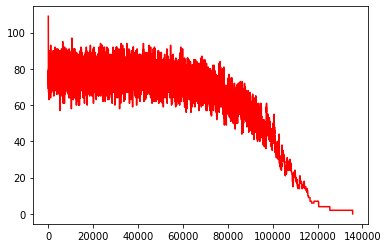

In [960]:
solved[13][1].show_information()

[[7 5 9 4 8 2 3 6 1]
 [6 2 3 1 5 9 8 4 7]
 [8 1 4 6 3 7 2 5 9]
 [1 7 8 2 4 3 6 9 5]
 [5 4 2 8 9 6 1 7 3]
 [9 3 6 5 7 1 4 8 2]
 [2 8 7 3 6 5 9 1 4]
 [4 9 1 7 2 8 5 3 6]
 [3 6 5 9 1 4 7 2 8]]
Number of iterations: 300105
Number of algorithm runs: 2
Correctness: True


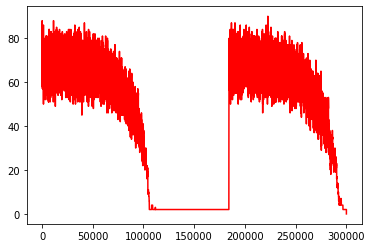

In [961]:
solved2[8][1].show_information()

Można zauważyć, że dwa powyższe rozwiązania, chociaż oba poprawne są różne. W tym fakcie może kryć się odpowiedź na pytanie, dlaczego algorytm symulowanego wyżarzania łatwiej znajdował rozwiązanie dla planszy z brakującymi 70 cyframi, niż dla planszy z brakującymi 50 cyframi. Wprawdzie przestrzeń możliwych stanów zwiększyła się, jednak zwiększyła sie również liczba stanów, dla których funkcja energii osiąga minimum.